In [1]:
import sys
sys.path += ['/home/lorenzo/Scrivania/My_projects/DeepWalk/P2Vec/Package/']  

from sklearn.decomposition import PCA
from node2vec.model import Node2Vec


from p2vec import *
from p2vecNS import *
from est import *
from DCSBM import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# set the parameters to generate the graph
N = 50000
n_clusters = 5
π = np.ones(n_clusters)/n_clusters
c = 10
c_out_v = np.linspace(1, 9.2, 20)
fluctuation = 0.

# set the parameters for the embedding algorithm
dim = 16
n_epochs = 18
walk_length = 10
k = 1
γ = 0.7
Λ = None
symmetric = True

dfNMI = pd.DataFrame(columns = ['α', 'p2v', 'SC', 'NS'])
dft = pd.DataFrame(columns = ['α', 'p2v', 'SC', 'NS'])

for i, c_out in enumerate(c_out_v):

    n = N
    # generate the label vector
    ℓ = np.concatenate([[j for i in range(int(π[j]*n))] for j in range(n_clusters)])
    n = len(ℓ)

    # generate a broad degree distribution
    θ = np.random.uniform(3,10, n)**6
    θ = θ/np.mean(θ)

    sq = np.mean(θ**2)
    α = (c - c_out)*np.sqrt(sq/c)

    # create the C matrix
    C = matrix_C(c_out, c, fluctuation, π)

    # generate the adjacency matrix
    A = adj(C, c, ℓ, θ)

    # limit the analysis to the giant component
    d = A@np.ones(n)
    idx = d > 0
    A = A[idx][:,idx]
    d = d[idx]
    n = len(d)
    ℓ = ℓ[idx]

    # create the probability matrix
    D_1 = diags(d**(-1))
    P = D_1.dot(A)

    # P2Vec
    Pv = [P]
    p2v = CreateEmbedding(Pv, Λ = Λ, dim = dim, n_epochs = n_epochs, walk_length = walk_length, k = k, 
                          symmetric = symmetric, verbose = False) 


    # SC
    t0 = time.time()
    X = community_detection(A, n_clusters = n_clusters , verbose = False)
    NMISC = computeNMI(X, ℓ)
    tSC = time.time() - t0

    # NS
#     src_nodes, dest_nodes = A.nonzero()

    t0 = time.time()
#     node2vec_model = Node2Vec(src_nodes, dest_nodes, graph_is_directed = False)
#     node2vec_model.simulate_walks(walk_length = 50, n_walks = 5, p = 1, q = 1, workers = 8, verbose = False)
#     node2vec_model.learn_embeddings(dimensions = dim, context_size = walk_length, 
#                                     epochs = n_epochs, workers = 8, verbose = False)
#     Y = node2vec_model.embeddings
    tNS = time.time() - t0


    print("[%-25s] %d%%" % ('='*(int((i+1)/len(c_out_v)*25)-1) + '>', (i+1)/(len(c_out_v))*100), end = '\r')

    NMIp2v = computeNMI(p2v.Φ, ℓ)
    NMISC = computeNMI(X, ℓ)
#     NMINS = computeNMI(Y, ℓ)
    NMINS = 0

    row = {'α':α, 'p2v': NMIp2v, 'SC': NMISC, 'NS': NMINS}
    dfNMI = dfNMI.append(row, ignore_index = True)

    row = {'α':α, 'p2v': p2v.exec_time, 'SC': tSC, 'NS': tNS}
    dft = dft.append(row, ignore_index = True)
        

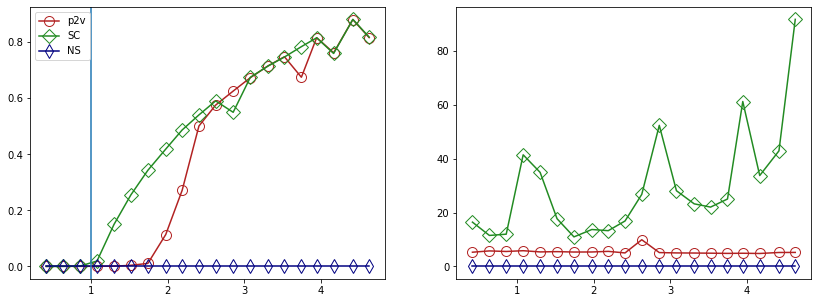

In [4]:
ms = 10

fig, ax = plt.subplots(1,2, figsize = (14, 5))

ax[0].plot(dfNMI.α, dfNMI.p2v, color = 'firebrick', marker = 'o', markersize = ms, fillstyle = 'none', label = 'p2v')
ax[0].plot(dfNMI.α, dfNMI.SC, color = 'forestgreen', marker = 'D', markersize = ms, fillstyle = 'none', label = 'SC')
ax[0].plot(dfNMI.α, dfNMI.NS, color = 'navy', marker = 'd', markersize = ms, fillstyle = 'none', label = 'NS')
ax[0].axvline(1)
ax[0].legend()

ax[1].plot(dft.α, dft.p2v, color = 'firebrick', marker = 'o', markersize = ms, fillstyle = 'none', label = 'p2v')
ax[1].plot(dft.α, dft.SC, color = 'forestgreen', marker = 'D', markersize = ms, fillstyle = 'none', label = 'SC')
ax[1].plot(dft.α, dft.NS, color = 'navy', marker = 'd', markersize = ms, fillstyle = 'none', label = 'NS')


plt.show();